In [1]:
import numpy as np
import pandas as pd
import plotly
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import re
import spacy
from wordcloud import WordCloud
import itertools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import zipfile

In [2]:
zf = zipfile.ZipFile("./data/fnn.csv.zip") 
df = pd.read_csv(zf.open('fnn.csv'))

In [3]:
df.shape

(15212, 8)

In [4]:
df['year'] = pd.DatetimeIndex(df['date'].apply(lambda x: x[:10])).year
df['date']=pd.DatetimeIndex(df['date'].apply(lambda x: x[:10]))

#### Cleaning data

In [5]:
df=df.rename(columns={"label_fnn": "label", "fullText_based_content":"text"}) #renaming columns for convinience

In [6]:
df.drop(['paragraph_based_content', 'speaker','id'], axis=1, inplace=True)

#### Descriptive analysis

In [7]:
fig = px.histogram(df, y='label', template='plotly_white', title='Number of fake data over time'
                   , color='label', barmode='group', color_discrete_sequence=["#FFA6C9","#7AE5F5"])
fig.update_layout(title = 'True/Fake news', width=600, template='plotly_white', font_size=12, font_color="#482683")
fig.show()

In [8]:
fig = px.histogram(df, x='year', template='plotly_white', title='Fake and real data over time'
                   , color='label', barmode='group', range_y=[1,1150], color_discrete_sequence=["#7AE5F5","#482683"])
fig.update_layout(template='plotly_white', font_size=12, font_color="#482683")
fig.show()


In [9]:
#combining title with main text
df['all_text'] = df.text.str.cat(df.statement, sep=' ')

In [10]:
#splitting dependent and independent variables
x = list(df['all_text'])
y = list(df['label'])

In [11]:
#split train/test data
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [12]:
#loading spacy 
import en_core_web_md
nlp = en_core_web_md.load()

In [13]:
def clean_text(corpus, model):
    """preprocess a string (tokens, stopwords, lowercase, lemma & stemming) returns the cleaned result
        params: corpus - a string
                model - a spacy model                
        returns: list of cleaned strings
    """    
    new_doc = []
    doc = model(corpus)
    for word in doc:
        if not word.is_stop and word.is_alpha:
            new_doc.append(word.lemma_.lower())
            final = ", ".join(map(str,new_doc))
    return final

In [14]:
clean_list = []
for i in x_train:
    clean = clean_text(i, nlp)
    clean_list.append(clean)   

In [15]:
x_train=clean_list

In [16]:
tv = TfidfVectorizer() 

In [17]:
tv.fit(x_train)

TfidfVectorizer()

In [18]:
#saving tfidf model
with open('./fake_news_flask/models/tv_model.p', 'wb') as f5:
    pickle.dump(tv, f5)

In [19]:
tv_corpus = tv.transform(x_train)

In [20]:
test_corpus = tv.transform(x_test)

In [21]:
def evaluate_model(m, xtrain, y_train, xtest, y_test):
    m.fit(xtrain, y_train)
    
    print("train accuracy: ", (m.score(xtrain, y_train) *100).round(2), " %")

# Cross validation
    val = cross_val_score(m, xtrain, y_train, cv=5, scoring='accuracy')
    print("cross validation accuracy: ", (val * 100).round(2))
    
    print('\n\033[1m' + "Test Data:")
    y_pred = m.predict(xtest)

    print('\033[0m'+"test accuracy: ", (m.score(xtest, y_test) *100).round(2), " %")
    print("precision score: ", (precision_score(y_test, y_pred, average='weighted') *100).round(2), " %")
    print("f1 score:", (f1_score(y_test, y_pred, average='weighted') *100).round(2), " %")  
   
    plot_confusion_matrix(m, xtest, y_test, normalize=None, cmap='Purples')

In [22]:
def RandForestCl(xtrain, y_train, xtest, y_test, maximum_depth):    
    m = RandomForestClassifier(max_depth=maximum_depth)  
    evaluate_model(m, xtrain, y_train, xtest, y_test)

#### Random Forest Classifier

train accuracy:  70.49  %
cross validation accuracy:  [65.91 65.34 65.82 65.91 66.11]

Test Data:
test accuracy:  63.4  %
precision score:  63.7  %
f1 score: 63.09  %


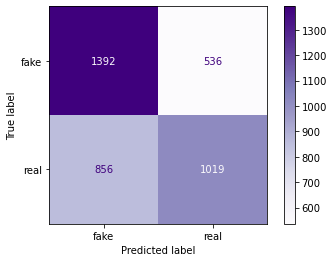

In [23]:
RandForestCl(tv_corpus, y_train, test_corpus, y_test,5)

In [37]:
rf=RandomForestClassifier()  

In [24]:
def LogReg(x_train, y_train, x_test, y_test):   
    m = LogisticRegression(C=1)
    evaluate_model(m, x_train, y_train, x_test, y_test)

#### Logistic Regression Classifier

train accuracy:  81.19  %
cross validation accuracy:  [67.53 65.64 67.7  65.69 67.03]

Test Data:
test accuracy:  66.68  %
precision score:  66.96  %
f1 score: 66.48  %


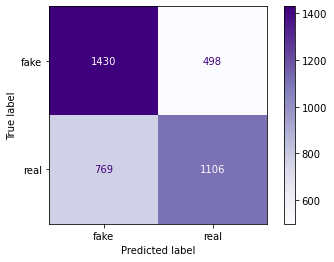

In [25]:
LogReg(tv_corpus, y_train, test_corpus, y_test)

In [26]:
def DecisionTreeCl(x_train, y_train, x_test, y_test, maximum_depth):
    m = DecisionTreeClassifier(max_depth = maximum_depth)    
    evaluate_model(m, x_train, y_train, x_test, y_test)

#### Decision Tree Classifier

train accuracy:  77.35  %
cross validation accuracy:  [63.01 63.06 65.12 64.07 64.23]

Test Data:
test accuracy:  61.61  %
precision score:  64.0  %
f1 score: 60.16  %


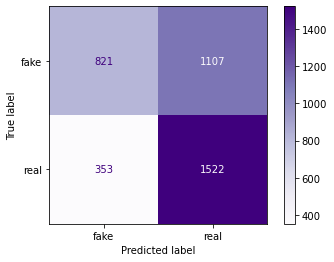

In [27]:
DecisionTreeCl(tv_corpus, y_train, test_corpus, y_test, 12)

In [28]:
NBpipeline = Pipeline([("TV", TfidfVectorizer()),
                       ("NaiveBayes", MultinomialNB())])

In [29]:
NBpipeline.fit(x_train, y_train) 

Pipeline(steps=[('TV', TfidfVectorizer()), ('NaiveBayes', MultinomialNB())])

#### Naive Bayes and Pipeline

train accuracy:  74.13  %
cross validation accuracy:  [64.07 63.54 64.33 63.01 64.09]

Test Data:
test accuracy:  63.98  %
precision score:  65.07  %
f1 score: 63.15  %


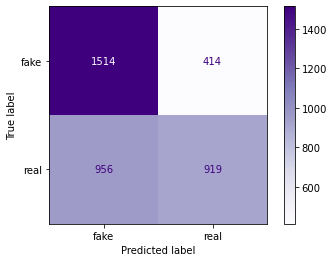

In [30]:
evaluate_model(NBpipeline, x_train, y_train, x_test, y_test)

#### Training and saving models

In [40]:
def train_models(x_train, y_train, maximum_depth):
    """Train Logistic regression, Random forest Classifier and Decision Tree Classifier"""
    
    lr = LogisticRegression(C=1e5)   
    trained_lr=lr.fit(x_train, y_train)
    
    rf = RandomForestClassifier(max_depth=maximum_depth) 
    trained_rf=rf.fit(x_train, y_train)
    
    dt = DecisionTreeClassifier(max_depth = maximum_depth) 
    trained_dt=dt.fit(x_train, y_train)
    
    return trained_lr, trained_rf, trained_dt

In [49]:
lr, rf, dt =train_models(tv_corpus, y_train, 10)

/Users/madinamukhambekova/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [50]:
#saving Logistic Regression model
with open('./fake_news_flask/models/lr_model.p', 'wb') as f1:
    pickle.dump(lr, f1)
#saving Random Forest Classifier model
with open('./fake_news_flask/models/rf_model.p', 'wb') as f2:
    pickle.dump(rf, f2)
#saving Decision Tree Classifier model
with open('./fake_news_flask/models/dt_model.p', 'wb') as f3:
    pickle.dump(dt, f3)

#### Prediction

In [51]:
def predict(input, trained_model):
    list1 = [input]
    test_corpus = tv.transform(list1)  
    final_input= pd.DataFrame(test_corpus.todense().round(2), columns=tv.get_feature_names())
    prediction = trained_model.predict_proba(final_input)
    prediction=prediction[0][0]

    return ("The news you submitted are", (prediction *100).round(2), "%", "fake")

In [52]:
with open('./fake_news_flask/models/predict.p', 'wb') as f4:
    pickle.dump(predict, f4)

In [53]:
test='The so-called "CIA torture report" has heightened debate over whether certain interrogation techniques used by the United States in the wake of the Sept. 11, 2001 terrorist attacks constituted torture.\nRhode Island Sen. Sheldon Whitehouse weighed in on Dec. 14 when he appeared on "Fox News Sunday" with host Chris Wallace and political consultant Karl Rove.\nIn the portion of the program that dealt with whether waterboarding, which simulates the feeling of drowning, constitutes torture, Whitehouse said there was precedent in the United States to conclude that it was.\n"We decided that waterboarding was torture back when we court-martialed American soldiers for waterboarding Philippine insurgents during the Philippine revolution," Whitehouse said .\n"We decided waterboarding was torture when we prosecuted Japanese soldiers as war criminals for waterboarding Americans during World War II, and we decided waterboarding was torture when the American court system described waterboarding as torture when Ronald Reagan and his Department of Justice prosecuted a Texas sheriff and several of his associates for waterboarding detainees."\nBecause the Philippine revolution, which dates back to the 1890s, is the earliest reference Whitehouse made, we decided to check out that part of his statement.\nWhile we were waiting for Whitehouse\'s office to respond to our request for documentation, we started poking around ourselves.\nThere\'s little doubt that what is now called waterboarding -- then known as water torture or by the odd name of the "water cure" -- was used by Americans in the Philippines after the U.S. gained colonial authority over the islands from the Spanish in 1898 under the terms of the treaty that ended the Spanish-American War.\nFilipinos had been recruited to help fight the Spanish but when the Spanish were vanquished, the Filipinos tried to gain their independence. The resulting guerilla war had some things in common with the U.S. interventions in Iraq and Afghanistan, complete with boobytraps, suspicions that all Filipinos were guerrilla fighters, and the depiction of the guerillas as treacherous fanatics.\nMost accounts we found report that an infantry captain named Edwin F. Glenn was found guilty of engaging in water torture during the war.\nGlenn was a judge advocate at the time he was involved in waterboarding. By the time he was court-martialed, he had been promoted to major. He was specifically charged with administering the "water cure" to a prominent Philippine resident named Tobeniano Ealdama, whom he suspected of collaborating with insurgents.\nWhitehouse\'s office cited a detailed 1903 Senate report on courts-martial in the Philippines. The section on Glenn accuses him of carrying out "a method of punishment commonly known in the Philippine Islands as the \'water cure;\' that is, did cause water to be introduced into the mouth and stomach of the said Ealdama against his will" around Nov. 27, 1900.\nGlenn admitted to the practice but defended it, arguing -- as waterboarding supporters do today -- that it saved lives. A military court didn\'t think that was sufficient justification. He was found guilty. But his sentence was light -- a one-month suspension and a $50 fine, which was the equivalent to more than $1,200 today.\nGlenn wasn\'t the only soldier to be court-martialed for administering the "water cure," and testimony in the Senate report makes it clear that this was frequently used to extract information.\nFirst Lt. Julien E. Gaujot, of the 10th U.S. Cavalry, was found guilty of doing it to three priests in January, 1902. He was suspended from command for three months, forfeiting $50 in pay per month for that period.\nThe military court made it clear that, in the cases of both men, the court was being lenient.\nLike Glenn, Gaujot admitted using water torture, saying he did it because he knew the priests were insurgents and "I knew that they possessed information that would be valuable to the American cause."\n"It was impossible to obtain reliable information regarding the insurgents from the inhabitants, who are, as a whole, crafty, lying, and treacherous, many of them being fanatical savages who respect no laws and whose every instinct is depraved," Glenn told the court.\nNot all of the courts-martial were successful.\nFor example, 1st Lt. Edwin A. Hickman of the First U.S. Cavalry was brought up on charges for ordering that two Filipinos be held upside down and the upper half of their bodies dunked in an open spring to extract information and to get the men to act as guides. He admitted doing it but argued that it wasn\'t unlawful.\nThe court acquitted Hickman because of "the abnormal and disgraceful methods of armed resistance to the authority of the United States; the treachery of the natives generally; the paramount necessity of obtaining information, and the belief on the part of the accused that the punishment administered was within the rules of war and under the instructions of superior military authority."\nIn these cases, Judge Advocate General George B. Davis said General Order #100, which dated back to 1863, "contains the requirement that military necessity does not admit of cruelty -- that is, the infliction of suffering for the sake of suffering or for revenge -- nor of maiming or wounding except in fight, nor of torture to extort confessions." In these cases, there was no emergency that required torture, Davis argued.\nOne might debate whether the "water cure" is the same as waterboarding. In both cases, the victim is lying down and restrained. With waterboarding, the face is sometimes covered by a towel with the body tilted to try to keep water in the upper airways and out of the lungs.\nWith the water cure, water went directly into the mouth and was forced into the stomach, causing a great deal of pain. In both instances, the goal is not to drown the victim, but to make things as unpleasant as possible. Both produce the sensation of being unable to breathe.\nEven if the water doesn\'t get into the lungs directly, the victim may vomit and inhale the vomit, which can be fatal.\nThe water cure was clearly effective in inducing fear. According to accounts in the Senate report, just the threat of repeating "the water cure" could be enough to break the will of recalcitrant Filipinos.\n"At a minimum, the techniques are substantially similar," said Whitehouse spokesman Seth Larson. The United States "decided waterboarding was torture back when we court-martialed American soldiers for waterboarding Philippine insurgents in the Philippine revolution.'

In [55]:
predict(test, lr)

('The news you submitted are', 99.79, '%', 'fake')

#### Most common words for the period from 2008-2020

#### Most common words for 2020

In [57]:
df2020=df[(df['date']>"2020-01-01")&(df['label']=="fake")]

In [58]:
clean2020 = []

In [59]:
for i in df2020['all_text']:
    cleaned = clean_text(i, nlp)
    clean2020.append(cleaned)   

In [60]:
news_str=" ".join(clean2020)
fc = Counter(news_str.split())
common_fake=fc.most_common(20)

In [61]:
data_fake = pd.DataFrame(common_fake,columns=['word','count'])

fig = px.bar(data_fake,
             color='word', 
             height=550, x="word",y="count",
             title="Top 20 words in fake news",
            color_discrete_sequence=["#7AE5F5","#FFA6C9", "#482683"],
             template="simple_white"
            )
fig.update_layout(showlegend= False, template='plotly_white', font_size=12, font_color="#482683")
fig.show()

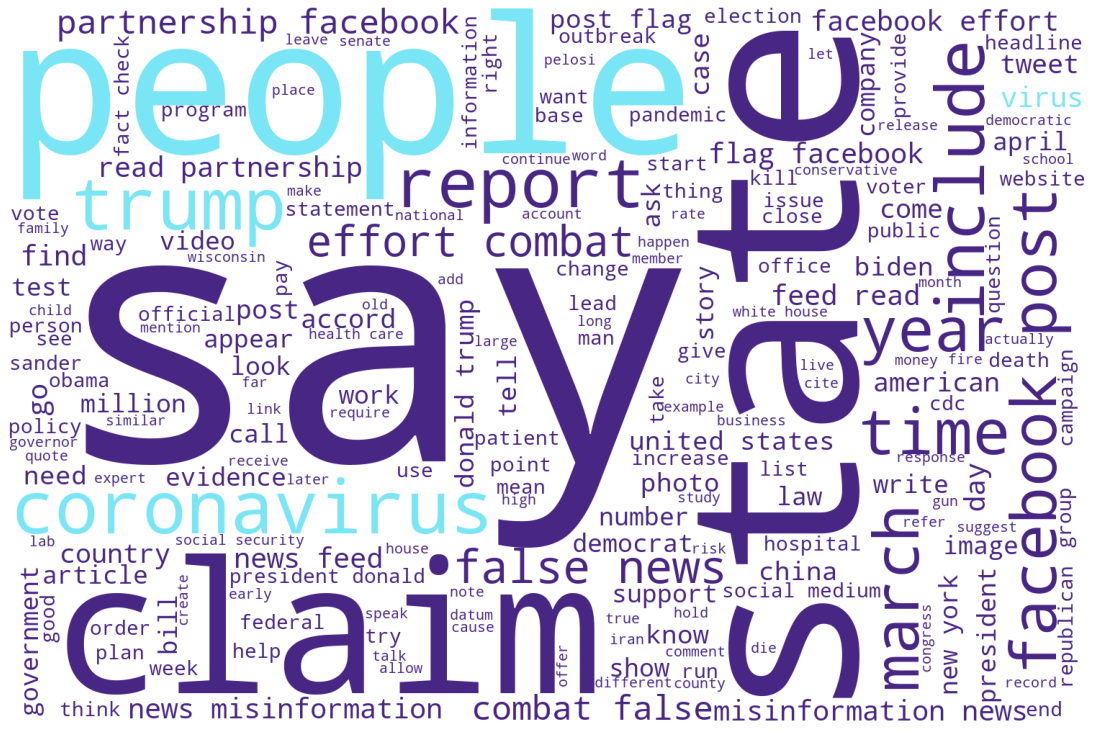

In [62]:
word_in_red1 = 'coronavirus'
word_in_red2= 'people'
word_in_red3= "virus"
word_in_red4="trump"

def color_word20(word, *args, **kwargs):
        if (word == word_in_red1) or (word == word_in_red2) or (word == word_in_red3) or (word == word_in_red4):
            color = "#7AE5F5" # red
        else:
            color = "#482683" # black
        return color

wordcloud20 = WordCloud(color_func=color_word20,
                       height=1000,
                       
                       width=1500,
                       background_color='white'
                         ).generate(" ".join(clean2020))
plt.figure(figsize = (15,15), facecolor = None)
plt.imshow(wordcloud20)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.savefig('cloud.png')
plt.show()

#### Sentiment Analysis

In [63]:
s = SentimentIntensityAnalyzer()

In [64]:
df2020=df[df['year']>2019]

In [65]:
df2020['sentiment_score'] = df2020['text'].apply(lambda x : s.polarity_scores(x)['compound'])

<ipython-input-65-cf0bd59f5332>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [66]:
fake_avg20=df2020[df2020['label']=='fake']['sentiment_score'].mean()

In [67]:
real_avg20=df2020[df2020['label']=='real']['sentiment_score'].mean()

In [68]:
df_fake20=df2020[df2020['label']=="fake"]

In [69]:
df_real20=df2020[df2020['label']=="real"]

In [71]:
df_fake20['sentiment_score'] = df_fake20['text'].apply(lambda x : s.polarity_scores(x)['compound'])

<ipython-input-71-c113bf7b3627>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [73]:
import plotly.graph_objects as go

fig = go.Figure(go.Indicator(
    mode = "number",
    value = fake_avg20,
    delta = {"reference": real_avg20, "valueformat": ".0f"},
    title = {"text": "Average sentiment score for fake news"},
    domain = {'y': [0, 1], 'x': [0.25, 0.75]}))

fig.add_trace(go.Scatter(
    y=df_fake20['sentiment_score'],
    x = df_fake20['date']))

fig.update_layout(yaxis = {'range': [-1, 1]})
fig.show()

In [75]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_real20['year'], y=df_real20['sentiment_score'],
                    mode='lines',
                    name='Real'))
fig.add_trace(go.Scatter(x=df_fake20['year'], y=df_fake20['sentiment_score'],
                    mode='lines+markers',
                    name='Fake'))

fig.show()

In [76]:
df_real20=df[df['label']=="real"]

In [77]:
df_real20['sentiment_score'] = df_real20['text'].apply(lambda x : s.polarity_scores(x)['compound'])

<ipython-input-77-2b79317634eb>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [79]:
fig = go.Figure(go.Indicator(
    mode = "number",
    value = real_avg20,
    delta = {"reference": fake_avg20, "valueformat": ".0f"},
    title = {"text": "Average sentiment score for real news"},
    domain = {'y': [0, 1], 'x': [0.25, 0.75]}))

fig.add_trace(go.Scatter(
    y=df_real20['sentiment_score'],
    x = df_real20['date']))

fig.update_layout(yaxis = {'range': [-1, 1]})
fig.show()